This notebook exercises some utility functions to load and explore the data.
It assumes that you have downloaded the training data and placed it in a *data* directory at the top of the repository.

We will use both plotly and matplotlib for displaying plots, charts and images.

In [1]:
import sys, os

sys.path.append("..")
import planet.util

import plotly
plotly.offline.init_notebook_mode(connected=True)

import matplotlib
import matplotlib.pyplot as plt

import numpy
import skimage.io

First we define the data paths.

In [2]:
data_dir = "../data"
train_tags_path = os.path.join(data_dir, "train_v2.csv")
train_images_path = os.path.join(data_dir, "train-jpg")

Then we load the tags and count their occurrences.

In [3]:
train_tags = planet.util.read_tags(train_tags_path)
train_tags_counts = planet.util.count_tags(train_tags)
train_tags_counts_fig = plotly.graph_objs.Figure({
    "data" : [
        plotly.graph_objs.Bar
        (
            x=list(train_tags_counts.keys()),
            y=list(train_tags_counts.values())
        )
    ],
    "layout" : {"title" : "Counts of Training Tags"}
})
plotly.offline.iplot(
    train_tags_counts_fig,
    filename=os.path.join(data_dir, "train_tags_counts.html")
)

The distribution of tags is very non-uniform. A few tags occur very frequently, like *primary* and *clear*, whereas others occur hardly at all, like *conventional_mine* and *blow_down*.

Remember that each sample can have many tags associated with it. Therefore, we now look at how frequently the tags co-occur with each other in the same sample.

In [27]:
tag_indices = planet.util.get_tag_indices(train_tags)
train_labels = planet.util.tags_to_labels(train_tags, tag_indices).astype(int)
train_tag_co_counts = train_labels.transpose().dot(train_labels)
train_tag_co_counts_diag = numpy.diagonal(train_tag_co_counts).copy()
numpy.fill_diagonal(train_tag_co_counts, 0)

train_tags_co_counts_fig = plotly.graph_objs.Figure({
    "data" : [
        plotly.graph_objs.Heatmap
        (
            z=train_tag_co_counts,
            x=list(tag_indices.keys()),
            y=list(tag_indices.keys()),
        )
    ],
    "layout" : {"title" : "Co-occurence Counts of Training Tags"}
})
plotly.offline.iplot(
    train_tags_co_counts_fig,
    filename=os.path.join(data_dir, "train_tags_co_counts.html")
)

Unfortunately, the co-occurrence counts are not that useful because they are dominated by the tags that occur frequently in the first place. In order to normalize this effect, we consider the conditional probability of seeing one tag given another.

In [38]:
train_tag_co_counts_float = train_tag_co_counts.astype(float)
train_tag_co_counts_sum = numpy.sum(train_tag_co_counts, axis=1, keepdims=True)
train_tag_cps = numpy.divide(train_tag_co_counts_float, train_tag_co_counts_sum,
                             out=numpy.zeros_like(train_tag_co_counts_float), where=train_tag_co_counts_sum!=0)

train_tags_cps_fig = plotly.graph_objs.Figure({
    "data" : [
        plotly.graph_objs.Heatmap
        (
            z=train_tag_cps,
            x=list(tag_indices.keys()),
            y=list(tag_indices.keys()),
        )
    ],
    "layout" : {"title" : "Co-occurence Conditional Probabilities of Training Tags"}
})
plotly.offline.iplot(
    train_tags_cps_fig,
    filename=os.path.join(data_dir, "train_tags_cps.html")
)

Again, we see that the frequent *primary* and *clear* tags dominate, as given most tags these co-occur with relatively high probability (i.e. greater than 0.2).

An obvious exception is that the *partly_cloudy* and *haze* tags never co-occur with *clear*, as one would expect. Also notice that, as we were told, the *cloudy* tag does not co-occur with any other tag. These kinds of deterministic rules may need to be built in to any tag predictor.

Even though there are no striking relationships between pairs of tags, there are a few interesting ones.

For example, given that the *blooming* tag occurs, almost all other tags except *primary* and *clear*, most of which are associated with human activity, do not occur, which may suggest that *blooming* may not frequently occur in the presence of human activitiy.

Another example is that given the *artisinal_mine* tag occurs, the *water* tag co-occurs with relatively high probability. I don't know of any reason for this, but it does stand out a little.

Finally, given certain tags like *selective_logging*, *conventional_mine* and *habitation*, the *road* tag co-occurs with higher probability than usual, as one would expect these man-made phenomena to often require roads.

Next, we plot an example image for each tag.

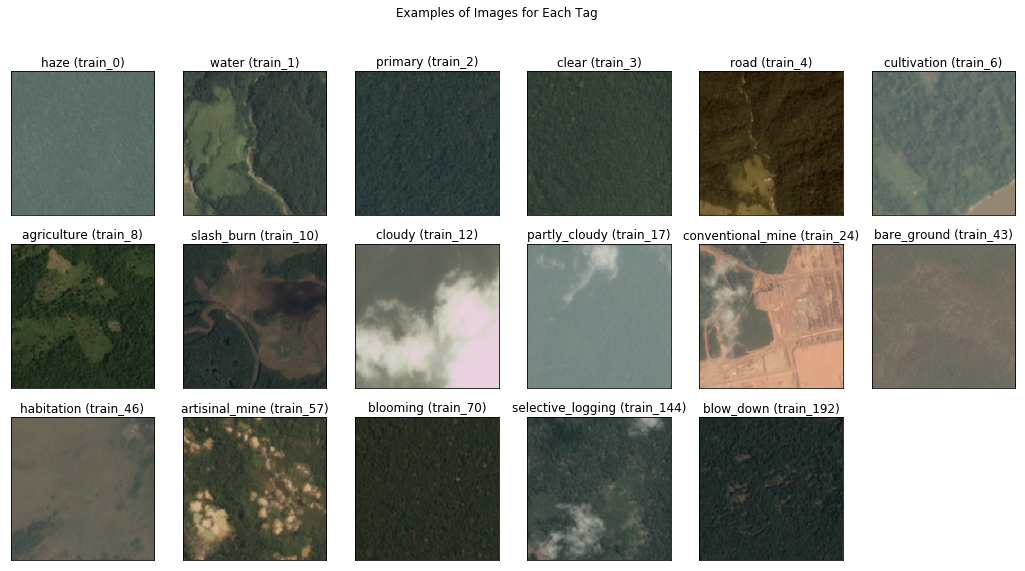

In [72]:
image_fig = plt.figure(figsize=(18, 9))
image_fig.suptitle('Examples of Images for Each Tag')
example_tags = set()
for sample, tag_list in train_tags.items():
    diff = set(tag_list) - example_tags
    if len(diff) > 0:
        tag = diff.pop()
        example_tags.add(tag)
        image = skimage.io.imread(os.path.join(data_dir, "train-jpg/{}.jpg".format(sample)))
        i = len(example_tags)
        ax = image_fig.add_subplot(3, 6, i)
        ax.set_title("{} ({})".format(tag, sample))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(image)
        if i >= 18 or i == len(train_tags_counts):
            break

plt.show()

A very preliminary observation is that **color** may play an important role is assigning tags to images. For example, *cloudy* clearly contains many white pixels, *primary* contains many green pixels and *habitation* contains many brown pixels. Other tags are more associated with structure and texture, such as *road* and *selective_logging*.

Therefore, next we compute the average RGB triple associated with each tag.

In [65]:
train_tag_rgb = numpy.zeros((len(tag_indices), 3))
index = 0

for sample, tag_list in train_tags.items():
    image = skimage.io.imread(os.path.join(data_dir, "train-jpg/{}.jpg".format(sample)))
    mean_rgb = numpy.mean(image, axis=(0, 1))
    for tag in tag_list:
        train_tag_rgb[tag_indices[tag], :] += mean_rgb
        
    index += 1
    if (index % 1000) == 0:
        print('Finished image {}'.format(index))
        
train_tag_rgb /= numpy.sum(train_labels, axis=0, keepdims=True).transpose()

Finished image 50
Finished image 100
Finished image 150
Finished image 200
Finished image 250
Finished image 300
Finished image 350
Finished image 400
Finished image 450
Finished image 500
Finished image 550
Finished image 600
Finished image 650
Finished image 700
Finished image 750
Finished image 800
Finished image 850
Finished image 900
Finished image 950
Finished image 1000
Finished image 1050
Finished image 1100
Finished image 1150
Finished image 1200
Finished image 1250
Finished image 1300
Finished image 1350
Finished image 1400
Finished image 1450
Finished image 1500
Finished image 1550
Finished image 1600
Finished image 1650
Finished image 1700
Finished image 1750
Finished image 1800
Finished image 1850
Finished image 1900
Finished image 1950
Finished image 2000
Finished image 2050
Finished image 2100
Finished image 2150
Finished image 2200
Finished image 2250
Finished image 2300
Finished image 2350
Finished image 2400
Finished image 2450
Finished image 2500
Finished image 2550


Finished image 20100
Finished image 20150
Finished image 20200
Finished image 20250
Finished image 20300
Finished image 20350
Finished image 20400
Finished image 20450
Finished image 20500
Finished image 20550
Finished image 20600
Finished image 20650
Finished image 20700
Finished image 20750
Finished image 20800
Finished image 20850
Finished image 20900
Finished image 20950
Finished image 21000
Finished image 21050
Finished image 21100
Finished image 21150
Finished image 21200
Finished image 21250
Finished image 21300
Finished image 21350
Finished image 21400
Finished image 21450
Finished image 21500
Finished image 21550
Finished image 21600
Finished image 21650
Finished image 21700
Finished image 21750
Finished image 21800
Finished image 21850
Finished image 21900
Finished image 21950
Finished image 22000
Finished image 22050
Finished image 22100
Finished image 22150
Finished image 22200
Finished image 22250
Finished image 22300
Finished image 22350
Finished image 22400
Finished imag

Finished image 39650
Finished image 39700
Finished image 39750
Finished image 39800
Finished image 39850
Finished image 39900
Finished image 39950
Finished image 40000
Finished image 40050
Finished image 40100
Finished image 40150
Finished image 40200
Finished image 40250
Finished image 40300
Finished image 40350
Finished image 40400
Finished image 40450


In [69]:
train_rgb_fig = plotly.graph_objs.Figure(
    data=[
        plotly.graph_objs.Bar
        (
            x=list(tag_indices.keys()),
            y=list(train_tag_rgb[:, 0]),
            name='Red',
            marker={'color' : 'rgb(255, 0, 0)'},
        ),
        plotly.graph_objs.Bar
        (
            x=list(tag_indices.keys()),
            y=list(train_tag_rgb[:, 1]),
            name='Green',
            marker={'color' : 'rgb(0, 255, 0)'},
        ),
        plotly.graph_objs.Bar
        (
            x=list(tag_indices.keys()),
            y=list(train_tag_rgb[:, 2]),
            name='Blue',
            marker={'color' : 'rgb(0, 0, 255)'},
        ),
    ],
    layout=plotly.graph_objs.Layout(barmode='group')
)

plotly.offline.iplot(
    train_rgb_fig,
    filename=os.path.join(data_dir, "train_tags_rgb.html")
)

While these RGB statistics are quite crude, they do confirm some of our suspicions.

For example, *artisinal_mine*, *bare_ground*, and *conventional_mine* contain more red than green, which is uncommon among other tags where green tends to dominate red as expected in images of the Amazon rainforest. The blue channel does not seem to vary in an interesting way, other than perhaps as an indication of the overall intensity level of image.

Also note that the clarity tags can be quite easily sorted by overall intensity in ascending order: *clear*, *partly_cloudy*, *haze*, and *cloudy*. This suggests that we may want to split the classification into two problems. One to assign a clarity label, which may be quite simple to solve, and another to assign the other labels, which is likely more complex.